## **INTERACTIVE GUI**

#### **Optical Inspired Rain Forest GUI**

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import random

class ORFRegressor:
    def __init__(self, population_size=20, generations=50):
        self.population_size = population_size
        self.generations = generations
        self.best_weights = None

    def _initialize_population(self, n_features):
        return [np.random.uniform(-1, 1, n_features + 1) for _ in range(self.population_size)]

    def _evaluate_fitness(self, weights, X, y):
        predictions = self._predict_internal(X, weights)
        return mean_squared_error(y, predictions)

    def _predict_internal(self, X, weights):
        return np.dot(X, weights[1:]) + weights[0]

    def fit(self, X, y):
        n_features = X.shape[1]
        population = self._initialize_population(n_features)

        for gen in range(self.generations):
            fitness_scores = [self._evaluate_fitness(ind, X, y) for ind in population]
            sorted_indices = np.argsort(fitness_scores)
            population = [population[i] for i in sorted_indices[:self.population_size // 2]]
            new_population = population.copy()

            while len(new_population) < self.population_size:
                parent = random.choice(population)
                mutation = np.random.normal(0, 0.1, size=n_features + 1)
                offspring = parent + mutation
                new_population.append(offspring)

            population = new_population

        self.best_weights = population[0]

    def predict(self, X):
        return self._predict_internal(X, self.best_weights)


def launch_gui():
    def load_dataset():
        filepath = filedialog.askopenfilename(filetypes=[("Excel or CSV files", "*.xlsx *.csv")])
        if not filepath:
            return
        try:
            if filepath.endswith(".csv"):
                df = pd.read_csv(filepath)
            elif filepath.endswith(".xlsx"):
                df = pd.read_excel(filepath)
            else:
                messagebox.showerror("Error", "Unsupported file format.")
                return

            if df.shape[1] != 5:
                messagebox.showerror("Error", "Dataset must have exactly 4 input columns and 1 output column.")
                return

            global X_train, X_test, y_train, y_test, model, feature_names, manual_entries
            feature_names = df.columns[:4].tolist()
            X = df.iloc[:, :4].values
            y = df.iloc[:, 4].values
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = ORFRegressor()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            result_label.config(text=f"Model trained.\nMSE on test set: {mse:.4f}")
            display_manual_input_fields()
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def display_manual_input_fields():
        for widget in manual_frame.winfo_children():
            widget.destroy()
        manual_entries.clear()
        for i, name in enumerate(feature_names):
            tk.Label(manual_frame, text=f"{name}:").grid(row=i, column=0, sticky='e')
            entry = tk.Entry(manual_frame)
            entry.grid(row=i, column=1)
            manual_entries.append(entry)

    def predict_manual():
        try:
            inputs = [float(entry.get()) for entry in manual_entries]
            X_input = np.array(inputs).reshape(1, -1)
            prediction = model.predict(X_input)[0]
            prediction_label.config(text=f"Predicted Output: {prediction:.4f}")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    root = tk.Tk()
    root.title("Optical-Inspired Rain Forest - Soil Property Predictor")
    root.geometry("450x500")

    tk.Button(root, text="Load Dataset (CSV or Excel)", command=load_dataset, width=40).pack(pady=10)
    result_label = tk.Label(root, text="Load dataset to train model.")
    result_label.pack(pady=5)

    manual_frame = tk.Frame(root)
    manual_frame.pack(pady=10)
    manual_entries = []

    tk.Button(root, text="Predict from Manual Input", command=predict_manual, width=30).pack(pady=10)
    prediction_label = tk.Label(root, text="Prediction will appear here.")
    prediction_label.pack()

    root.mainloop()


if __name__ == "__main__":
    launch_gui()


#### **Interactive GUI**

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import ipywidgets as widgets
from IPython.display import display, clear_output

# Upload widget
file_upload = widgets.FileUpload(accept='.csv,.xls,.xlsx', multiple=False)
output = widgets.Output()

display(widgets.HTML("<h3>Upload Dataset (.csv, .xls, .xlsx) with 4 input columns and 1 output</h3>"))
display(file_upload)
display(output)

def process_upload(change):
    output.clear_output()
    with output:
        if file_upload.value:
            uploaded_file = file_upload.value[0]
            content = uploaded_file['content']
            filename = uploaded_file['name'].lower()

            try:
                content_bytes = bytes(content)
                if filename.endswith('.csv'):
                    df = pd.read_csv(io.StringIO(content_bytes.decode('utf-8')))
                elif filename.endswith(('.xls', '.xlsx')):
                    df = pd.read_excel(io.BytesIO(content_bytes))
                else:
                    print(" Unsupported file format.")
                    return
            except Exception as e:
                print(f" Error reading file: {e}")
                return

            display(df.head())

            if df.shape[1] != 5:
                print(" Error: File must contain exactly 4 input columns and 1 output column.")
                return

            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
            print(" Training all models for comparison...")

            models_params = {
                'Random Forest': (
                    RandomForestRegressor(),
                    {'n_estimators': [50, 100], 'max_depth': [5, 10]}
                ),
                'XGBoost': (
                    XGBRegressor(verbosity=0),
                    {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
                ),
                'KNN': (
                    KNeighborsRegressor(),
                    {'n_neighbors': [3, 5, 7]}
                ),
                'Linear Regression': (
                    LinearRegression(),
                    {}
                ),
                'SVR': (
                    SVR(),
                    {'C': [1, 10], 'kernel': ['rbf', 'linear']}
                ),
            }

            results = []

            for name, (model, params) in models_params.items():
                grid = GridSearchCV(model, params, cv=3, scoring='r2')
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                y_pred = best_model.predict(X_test)

                results.append({
                    'Model': name,
                    'Best Params': grid.best_params_,
                    'R2': r2_score(y_test, y_pred),
                    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'MAE': mean_absolute_error(y_test, y_pred),
                    'MSE': mean_squared_error(y_test, y_pred),
                    'Estimator': best_model
                })

            results_df = pd.DataFrame(results).drop(columns='Estimator')
            display(results_df)

            # Plotting metrics
            fig, axes = plt.subplots(1, 3, figsize=(20, 5))

            for metric in ['R2', 'RMSE', 'MAE', 'MSE']:
                axes[0].bar(results_df['Model'], results_df[metric], label=metric)
            axes[0].set_title("Model Comparison (Overlayed)")
            axes[0].legend()

            metrics_only = results_df.set_index('Model')[['R2', 'RMSE', 'MAE', 'MSE']]
            sns.heatmap(metrics_only, annot=True, fmt=".2f", cmap='YlGnBu', ax=axes[1])
            axes[1].set_title("Metrics Heatmap")

            sns.barplot(data=results_df, x='Model', y='R2', ax=axes[2])
            axes[2].set_title("R² Scores")

            plt.tight_layout()
            plt.show()

            print("\n Now select one model to use for prediction:")
            model_dropdown = widgets.Dropdown(
                options=[r['Model'] for r in results],
                description='Model:',
            )
            run_button = widgets.Button(description="Predict ")

            print("\n Enter Input Values for Prediction:")
            input_widgets = {
                col: widgets.FloatText(description=col, step=0.01) for col in X.columns
            }
            for w in input_widgets.values():
                display(w)

            display(model_dropdown)
            display(run_button)

            def on_run_clicked(b):
                clear_output(wait=True)
                display(output)
                with output:
                    selected_name = model_dropdown.value
                    selected_model = next(r['Estimator'] for r in results if r['Model'] == selected_name)

                    user_input = [input_widgets[col].value for col in X.columns]
                    input_df = pd.DataFrame([user_input], columns=X.columns)
                    input_scaled = scaler.transform(input_df)
                    prediction = selected_model.predict(input_scaled)[0]

                    output_name = y.name
                    print(f"\n Predicted {output_name} using {selected_name}: {prediction:.2f}")  # No plot shown

            run_button.on_click(on_run_clicked)

file_upload.observe(process_upload, names='value')


HTML(value='<h3>Upload Dataset (.csv, .xls, .xlsx) with 4 input columns and 1 output</h3>')

FileUpload(value=(), accept='.csv,.xls,.xlsx', description='Upload')

Output()

#### **GUI WITH LIMITED OPTIONS**

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class ModelApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Model Comparison & Prediction")
        self.df = None
        self.models = {}
        self.scaler = None
        self.X_test = None
        self.y_test = None
        self.results_df = None
        self.feature_names = None

        tk.Button(root, text="Upload Dataset (.csv/.xlsx)", command=self.load_data).pack(pady=10)

    def load_data(self):
        file_path = filedialog.askopenfilename(filetypes=[("CSV files", ".csv"), ("Excel files", ".xlsx")])
        if not file_path:
            return
        try:
            if file_path.endswith(".csv"):
                self.df = pd.read_csv(file_path)
            else:
                self.df = pd.read_excel(file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read file: {e}")
            return

        if self.df.shape[1] != 5:
            messagebox.showerror("Error", "Dataset must have exactly 4 input features and 1 output.")
            return

        self.feature_names = list(self.df.columns[:-1])
        self.train_models()

    def train_models(self):
        X = self.df.iloc[:, :-1]
        y = self.df.iloc[:, -1]
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_train, self.X_test, y_train, self.y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        models = {
            'XGBoost': (XGBRegressor(verbosity=0), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}),
            'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [5, 10]}),
            'SVR': (SVR(), {'C': [1, 10], 'kernel': ['rbf', 'linear']}),
            'KNN': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
            'Linear Regression': (LinearRegression(), {})
        }

        results = []
        for name, (model, params) in models.items():
            grid = GridSearchCV(model, params, cv=3, scoring='r2')
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(self.X_test)
            self.models[name] = best_model
            results.append({
                'Model': name,
                'Best Params': str(grid.best_params_),
                'R2': round(r2_score(self.y_test, y_pred), 4),
                'RMSE': round(np.sqrt(mean_squared_error(self.y_test, y_pred)), 4),
                'MAE': round(mean_absolute_error(self.y_test, y_pred), 4),
                'MSE': round(mean_squared_error(self.y_test, y_pred), 4),
            })

        self.results_df = pd.DataFrame(results)
        self.show_results()

    def show_results(self):
        result_win = tk.Toplevel(self.root)
        result_win.title("Model Comparison Results")

        columns = list(self.results_df.columns)
        tree = ttk.Treeview(result_win, columns=columns, show='headings', height=10)
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, width=130, anchor=tk.CENTER)
        for _, row in self.results_df.iterrows():
            tree.insert("", tk.END, values=list(row))

        scrollbar = ttk.Scrollbar(result_win, orient="vertical", command=tree.yview)
        tree.configure(yscroll=scrollbar.set)
        tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        tk.Button(result_win, text="Show Metric Heatmap", command=self.plot_heatmap).pack(pady=5)
        tk.Button(result_win, text="Predict Using Model", command=self.predict_manual).pack(pady=5)

    def plot_heatmap(self):
        heat_win = tk.Toplevel(self.root)
        heat_win.title("Heatmap")
        metrics = self.results_df.set_index('Model')[['R2', 'RMSE', 'MAE', 'MSE']]
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(metrics, annot=True, cmap="YlGnBu", fmt=".2f", ax=ax)
        ax.set_title("Model Performance Metrics Heatmap")
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=heat_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def predict_manual(self):
        predict_win = tk.Toplevel(self.root)
        predict_win.title("Manual Prediction")

        tk.Label(predict_win, text="Select Model:").grid(row=0, column=0, columnspan=2, pady=5)
        model_choice = tk.StringVar(predict_win)
        model_dropdown = ttk.Combobox(predict_win, textvariable=model_choice, values=list(self.models.keys()), state='readonly')
        model_dropdown.grid(row=1, column=0, columnspan=2, pady=5)
        model_dropdown.current(0)

        entry_fields = []
        for i, feature in enumerate(self.feature_names):
            tk.Label(predict_win, text=f"{feature} :").grid(row=i + 2, column=0, padx=5, pady=2, sticky=tk.E)
            entry = tk.Entry(predict_win)
            entry.grid(row=i + 2, column=1, padx=5, pady=2, sticky=tk.W)
            entry_fields.append(entry)

        def do_predict():
            try:
                input_values = [float(entry.get()) for entry in entry_fields]
                input_df = pd.DataFrame([input_values], columns=self.feature_names)
                input_scaled = self.scaler.transform(input_df)
                model = self.models[model_choice.get()]
                pred = model.predict(input_scaled)[0]
                messagebox.showinfo("Prediction", f"Predicted output: {pred:.2f}")
            except ValueError:
                messagebox.showerror("Error", "Please enter valid numerical inputs.")

        tk.Button(predict_win, text="Predict", command=do_predict).grid(row=len(self.feature_names) + 2, column=0, columnspan=2, pady=10)


if __name__ == "__main__":
    root = tk.Tk()
    app = ModelApp(root)
    root.mainloop()


#### **FINAL GUI**

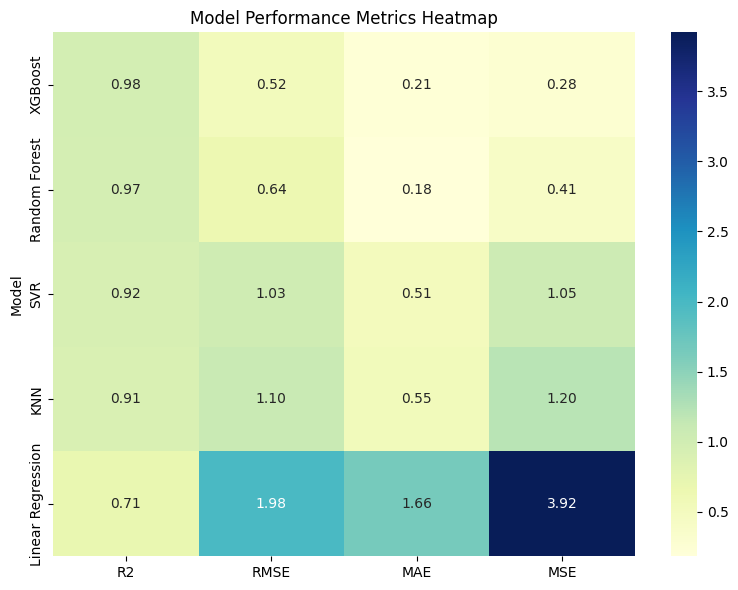

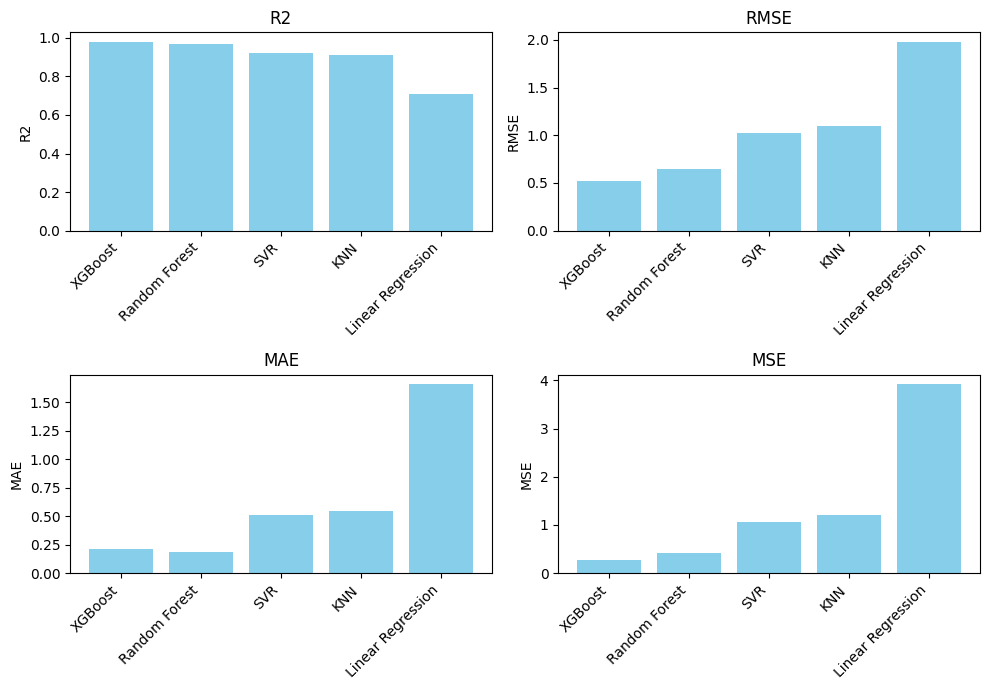

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class ModelApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Model Comparison & Prediction")
        self.df = None
        self.models = {}
        self.scaler = None
        self.X_test = None
        self.y_test = None
        self.results_df = None
        self.feature_names = None
        self.output_name = None  # <-- Store output column name

        tk.Button(root, text="Upload Dataset (.csv/.xlsx)", command=self.load_data).pack(pady=10)

    def load_data(self):
        file_path = filedialog.askopenfilename(filetypes=[("CSV files", ".csv"), ("Excel files", ".xlsx")])
        if not file_path:
            return
        try:
            if file_path.endswith(".csv"):
                self.df = pd.read_csv(file_path)
            else:
                self.df = pd.read_excel(file_path)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read file: {e}")
            return

        if self.df.shape[1] != 5:
            messagebox.showerror("Error", "Dataset must have exactly 4 input features and 1 output.")
            return

        self.feature_names = list(self.df.columns[:-1])
        self.output_name = self.df.columns[-1]  # <-- Capture output column name
        self.train_models()

    def train_models(self):
        X = self.df.iloc[:, :-1]
        y = self.df.iloc[:, -1]
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_train, self.X_test, y_train, self.y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        models = {
            'XGBoost': (XGBRegressor(verbosity=0), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}),
            'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [5, 10]}),
            'SVR': (SVR(), {'C': [1, 10], 'kernel': ['rbf', 'linear']}),
            'KNN': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
            'Linear Regression': (LinearRegression(), {})
        }

        results = []
        for name, (model, params) in models.items():
            grid = GridSearchCV(model, params, cv=3, scoring='r2')
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(self.X_test)
            self.models[name] = best_model
            results.append({
                'Model': name,
                'Best Params': str(grid.best_params_),
                'R2': round(r2_score(self.y_test, y_pred), 4),
                'RMSE': round(np.sqrt(mean_squared_error(self.y_test, y_pred)), 4),
                'MAE': round(mean_absolute_error(self.y_test, y_pred), 4),
                'MSE': round(mean_squared_error(self.y_test, y_pred), 4),
            })

        self.results_df = pd.DataFrame(results)
        self.show_results()

    def show_results(self):
        result_win = tk.Toplevel(self.root)
        result_win.title("Model Comparison Results")

        columns = list(self.results_df.columns)
        tree = ttk.Treeview(result_win, columns=columns, show='headings', height=10)
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, width=130, anchor=tk.CENTER)
        for _, row in self.results_df.iterrows():
            tree.insert("", tk.END, values=list(row))

        scrollbar = ttk.Scrollbar(result_win, orient="vertical", command=tree.yview)
        tree.configure(yscroll=scrollbar.set)

        tree.grid(row=0, column=0, columnspan=4, padx=10, pady=10, sticky="nsew")
        scrollbar.grid(row=0, column=4, sticky="ns")

        btn_frame = tk.Frame(result_win)
        btn_frame.grid(row=1, column=0, columnspan=5, pady=10)

        tk.Button(btn_frame, text="Save as CSV", command=self.save_to_csv).grid(row=0, column=0, padx=5)
        tk.Button(btn_frame, text="Show Metric Heatmap", command=lambda: self.plot_heatmap(result_win)).grid(row=0, column=1, padx=5)
        tk.Button(btn_frame, text="Show Metric Bar Chart", command=lambda: self.plot_bar_chart(result_win)).grid(row=0, column=2, padx=5)
        tk.Button(btn_frame, text="Predict Using Model", command=self.predict_manual).grid(row=0, column=3, padx=5)

        result_win.grid_rowconfigure(0, weight=1)
        result_win.grid_columnconfigure(0, weight=1)

    def save_to_csv(self):
        file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
        if file_path:
            try:
                self.results_df.to_csv(file_path, index=False)
                messagebox.showinfo("Success", f"Results saved to {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to save file: {e}")

    def plot_heatmap(self, master_window):
        chart_win = tk.Toplevel(master_window)
        chart_win.title("Heatmap")

        metrics = self.results_df.set_index('Model')[['R2', 'RMSE', 'MAE', 'MSE']]
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(metrics, annot=True, cmap="YlGnBu", fmt=".2f", ax=ax)
        ax.set_title("Model Performance Metrics Heatmap")
        fig.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=chart_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def plot_bar_chart(self, master_window):
        chart_win = tk.Toplevel(master_window)
        chart_win.title("Bar Chart Comparison")

        metrics = ['R2', 'RMSE', 'MAE', 'MSE']
        fig, axs = plt.subplots(2, 2, figsize=(10, 7))
        axs = axs.ravel()

        x = np.arange(len(self.results_df['Model']))

        for i, metric in enumerate(metrics):
            axs[i].bar(x, self.results_df[metric], color='skyblue')
            axs[i].set_title(metric)
            axs[i].set_ylabel(metric)
            axs[i].set_xticks(x)
            axs[i].set_xticklabels(self.results_df['Model'], rotation=45, ha='right')

        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=chart_win)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def predict_manual(self):
        predict_win = tk.Toplevel(self.root)
        predict_win.title("Manual Prediction")

        tk.Label(predict_win, text="Select Model:").grid(row=0, column=0, columnspan=2, pady=5)
        model_choice = tk.StringVar(predict_win)
        model_dropdown = ttk.Combobox(predict_win, textvariable=model_choice, values=list(self.models.keys()), state='readonly')
        model_dropdown.grid(row=1, column=0, columnspan=2, pady=5)
        model_dropdown.current(0)

        entry_fields = []
        for i, feature in enumerate(self.feature_names):
            tk.Label(predict_win, text=f"{feature} :").grid(row=i + 2, column=0, padx=5, pady=2, sticky=tk.E)
            entry = tk.Entry(predict_win)
            entry.grid(row=i + 2, column=1, padx=5, pady=2, sticky=tk.W)
            entry_fields.append(entry)

        result_label = tk.Label(predict_win, text="", font=("Arial", 12), fg="blue")
        result_label.grid(row=len(self.feature_names) + 3, column=0, columnspan=2, pady=10)

        def do_predict():
            try:
                input_values = [float(entry.get()) for entry in entry_fields]
                input_df = pd.DataFrame([input_values], columns=self.feature_names)
                input_scaled = self.scaler.transform(input_df)
                model = self.models[model_choice.get()]
                pred = model.predict(input_scaled)[0]
                result_label.config(text=f"Predicted {self.output_name}: {pred:.2f}", fg="blue")
            except ValueError:
                result_label.config(text=" Please enter valid numerical inputs.", fg="red")

        tk.Button(predict_win, text="Predict", command=do_predict).grid(row=len(self.feature_names) + 2, column=0, columnspan=2, pady=5)


if __name__ == "__main__":
    root = tk.Tk()
    app = ModelApp(root)
    root.mainloop()
